# 05_preprocess_nisar_hh — NISAR GCOV HH (HHHH) → σ⁰ → reproject to UTM 200 m

This notebook reads **NISAR GCOV** granules (HDF5) from S3, computes **σ⁰ HH** from covariance HHHH with the
RTC normalization factor, and reprojects to the **UTM 200 m template** created in `02_bbox_to_grid.ipynb`.

### Pipeline
1. Load ROI/target grid template
2. Read NISAR GCOV HDF5 from S3 (authenticated via ASF temporary credentials)
3. Extract grids:
   - `/science/LSAR/GCOV/grids/frequencyA/HHHH` (linear power)
   - `/science/LSAR/GCOV/grids/frequencyA/rtcAreaNormalizationFactorGamma0ToSigma0` (unitless)
   - `/science/LSAR/GCOV/grids/frequencyA/xCoordinates` (m)
   - `/science/LSAR/GCOV/grids/frequencyA/yCoordinates` (m)
   - `/science/LSAR/GCOV/grids/frequencyA/projection` (EPSG code)
4. Compute **σ⁰ (linear)** = `HHHH * rtcFactor` → reproject (bilinear) to template in **linear power**
5. Convert to **dB** and write GeoTIFF aligned to the template

**Why reproject in linear space?** Resampling backscatter in dB can bias values. We resample in linear power and
convert to dB at the end.


In [6]:
import os, math, json
from pathlib import Path
import numpy as np
import pandas as pd
import yaml
import h5py, s3fs
import rasterio
from rasterio.crs import CRS
from rasterio.transform import from_origin
from rasterio.warp import reproject, Resampling
from datetime import datetime
from maap.maap import MAAP
from pystac_client import Client
print('✅ Imports ok')

✅ Imports ok


In [7]:
cfg = yaml.safe_load(open('../config/project.yaml'))
tgrid = cfg.get('target_grid', {})
template_path = Path(tgrid.get('template_path', '../data/outputs/aligned/_grid_template.tif'))
if not template_path.exists():
    raise FileNotFoundError('Template grid not found. Run 02_bbox_to_grid.ipynb first.')
with rasterio.open(template_path) as tmp:
    dst_crs = tmp.crs
    dst_transform = tmp.transform
    dst_height = tmp.height
    dst_width = tmp.width
    dst_nodata = tmp.nodata
print('Template:', template_path)
print('Target CRS:', dst_crs, '| shape:', (dst_height, dst_width))

Template: ../data/outputs/aligned/_grid_template.tif
Target CRS: EPSG:32611 | shape: (623, 469)


## 1) Discover NISAR GCOV via MAAP STAC

In [8]:
# ---------------------------------------------------------------------
# 1) Discover NISAR GCOV via MAAP STAC
# ---------------------------------------------------------------------
maap = MAAP()
catalog = "https://stac.maap-project.org/"
client = Client.open(catalog)

# Search NISAR simulated GCOV
search = client.search(collections=["nisar-sim"])
items = list(search.items())
print(f"Found {len(items)} items in 'nisar-sim' collection")

# Pick the first available GCOV asset
s3_link = None
for item in items:
    if asset := item.assets.get("GCOV"):
        s3_link = asset.extra_fields["alternate"]["href"]
        print("Found GCOV asset in:", item.id)
        break

if not s3_link:
    raise RuntimeError("No GCOV S3 asset found in STAC search.")

print("✅ Using S3 link:", s3_link)

Found 12 items in 'nisar-sim' collection
Found GCOV asset in: NISAR_L2_PR_GCOV_001_005_A_219_4020_SHNA_A_20081012T060910_20081012T060926_P01101_F_N_J_001
✅ Using S3 link: s3://sds-n-cumulus-prod-nisar-sample-data/GCOV/ALOS1_Rosamond_20081012/NISAR_L2_PR_GCOV_001_005_A_219_4020_SHNA_A_20081012T060910_20081012T060926_P01101_F_N_J_001.h5


In [9]:
# ---------------------------------------------------------------------
# 2) Get ASF temporary credentials
# ---------------------------------------------------------------------
ASF_S3_CRED_ENDPOINT = "https://nisar.asf.earthdatacloud.nasa.gov/s3credentials"
creds = maap.aws.earthdata_s3_credentials(ASF_S3_CRED_ENDPOINT)
fs = s3fs.S3FileSystem(
    anon=False,
    key=creds["accessKeyId"],
    secret=creds["secretAccessKey"],
    token=creds["sessionToken"],
    client_kwargs={"region_name": "us-west-2"},
)
print("✅ ASF temporary S3 credentials ready")

✅ ASF temporary S3 credentials ready


In [16]:
# ---------------------------------------------------------------------
# 4) Helper functions
# ---------------------------------------------------------------------
DS_HHHH = "/science/LSAR/GCOV/grids/frequencyA/HHHH"
DS_RTC = "/science/LSAR/GCOV/grids/frequencyA/rtcAreaNormalizationFactorGamma0ToSigma0"
DS_X = "/science/LSAR/GCOV/grids/frequencyA/xCoordinates"
DS_Y = "/science/LSAR/GCOV/grids/frequencyA/yCoordinates"
DS_EPSG = "/science/LSAR/GCOV/grids/frequencyA/projection"

def _affine_from_coords(x, y):
    """Derive affine transform from 1D coordinate vectors."""
    xres = float(np.median(np.diff(x)))
    yres = float(np.median(np.diff(y)))
    ulx = float(x.min())
    uly = float(y.max())
    return from_origin(ulx, uly, abs(xres), abs(yres))

def read_nisar_sigma0_linear(s3_href, fs):
    """Read σ⁰ linear from NISAR GCOV HDF5 on S3."""
    path = s3_href.replace("s3://", "")
    with fs.open(path, "rb") as fobj, h5py.File(fobj, "r") as h5:
        proj_epsg = int(h5[DS_EPSG][()])
        x = h5[DS_X][...].astype("float64")
        y = h5[DS_Y][...].astype("float64")
        H = h5[DS_HHHH][...].astype("float64")
        rtc = 1
        # rtc = h5[DS_RTC][...].astype("float64") if DS_RTC in h5 else None
        # Mask fills
        dset = h5[DS_HHHH]
        fill = None
        for k in ("_FillValue","fillValue","FillValue","MissingValue","missing_value"):
            if k in dset.attrs:
                fill = float(np.array(dset.attrs[k]).squeeze()); break
        if fill is not None:
            H[H == fill] = np.nan
        if "valid_min" in dset.attrs:
            H[H < float(np.array(dset.attrs["valid_min"]).squeeze())] = np.nan
        if "valid_max" in dset.attrs:
            H[H > float(np.array(dset.attrs["valid_max"]).squeeze())] = np.nan
        if rtc is not None:
            H = H * rtc
        H[H <= 0] = np.nan
        src_crs = CRS.from_epsg(proj_epsg)
        src_transform = _affine_from_coords(x, y)
        return H, src_crs, src_transform

def power_to_db(arr_lin):
    with np.errstate(divide="ignore", invalid="ignore"):
        return 10.0 * np.log10(arr_lin)

print("✅ Helper functions ready")

✅ Helper functions ready


In [17]:
# ---------------------------------------------------------------------
# 5) Process one GCOV tile
# ---------------------------------------------------------------------
print("Processing:", s3_link)
sig0_lin, src_crs, src_transform = read_nisar_sigma0_linear(s3_link, fs)

dst_lin = np.full((dst_height, dst_width), np.nan, dtype="float32")

reproject(
    source=sig0_lin.astype("float32"),
    destination=dst_lin,
    src_transform=src_transform,
    src_crs=src_crs,
    dst_transform=dst_transform,
    dst_crs=dst_crs,
    src_nodata=np.nan,
    dst_nodata=np.nan,
    resampling=Resampling.bilinear,
)

dst_db = power_to_db(dst_lin)

# ---------------------------------------------------------------------
# 6) Write aligned GeoTIFF
# ---------------------------------------------------------------------
out_dir = Path("../data/outputs/aligned/nisar")
out_dir.mkdir(parents=True, exist_ok=True)
out_path = out_dir / "nisar_hh_sigma0_db.tif"

with rasterio.open(template_path) as tmp:
    profile = tmp.profile
profile.update(dtype="float32", count=1, compress="deflate", tiled=True, nodata=np.nan)

with rasterio.open(out_path, "w", **profile) as ds:
    ds.write(dst_db, 1)

meta = {"source": s3_link, "note": "σ⁰ HH in dB; linear resampling to template then dB"}
with open(out_dir / "nisar_hh_sigma0_db_meta.json", "w") as f:
    json.dump(meta, f, indent=2)

print("✅ Wrote:", out_path)

Processing: s3://sds-n-cumulus-prod-nisar-sample-data/GCOV/ALOS1_Rosamond_20081012/NISAR_L2_PR_GCOV_001_005_A_219_4020_SHNA_A_20081012T060910_20081012T060926_P01101_F_N_J_001.h5
✅ Wrote: ../data/outputs/aligned/nisar/nisar_hh_sigma0_db.tif


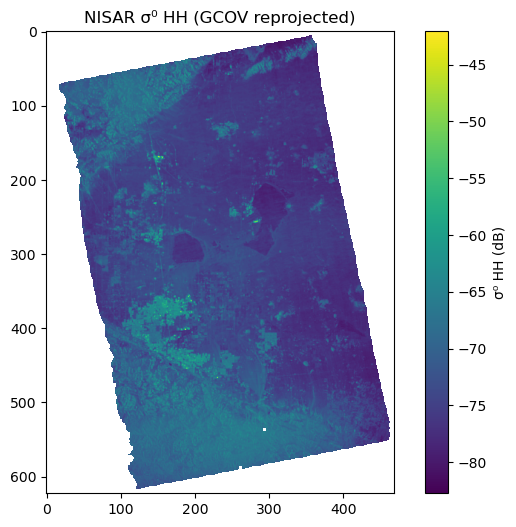

In [18]:
import matplotlib.pyplot as plt
# ---------------------------------------------------------------------
# 7) Quicklook plot
# ---------------------------------------------------------------------
plt.figure(figsize=(8,6))
im = plt.imshow(dst_db, cmap="viridis")
plt.colorbar(im, label="σ⁰ HH (dB)")
plt.title("NISAR σ⁰ HH (GCOV reprojected)")
plt.show()